<font size="+3"><strong>Predicting Apartment Prices in Mexico City</strong></font>

In [51]:
# Import libraries here
import warnings
from glob import glob
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

## Import

Write a `wrangle` function that takes the name of a CSV file as input and returns a DataFrame. The function should do the following steps:

1. Subset the data in the CSV file and return only apartments in Mexico City (`"Distrito Federal"`) that cost less than \$100,000.
2. Remove outliers by trimming the bottom and top 10\% of properties in terms of `"surface_covered_in_m2"`.
3. Create separate `"lat"` and `"lon"` columns.
4. Mexico City is divided into [15 boroughs](https://en.wikipedia.org/wiki/Boroughs_of_Mexico_City). Create a `"borough"` feature from the `"place_with_parent_names"` column.
5. Drop columns that are more than 50\% null values.
6. Drop columns containing low- or high-cardinality categorical values.
7. Drop any columns that would constitute leakage for the target `"price_aprox_usd"`.
8. Drop any columns that would create issues of multicollinearity.

In [52]:
# Build your `wrangle` function
def wrangle(filepath):
    # Read CSV file
    df = pd.read_excel(filepath)

    # Subset apartments in "Distrito Federal" that cost less than $100.000
    mask_apt = df["property_type"] == "apartment"
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_apt & mask_ba & mask_price]

    # Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1,0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Create separate "lat" and "lon" columns
    df[["lat","lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Create a "borough" feature from the "place_with_parent_names" column.
    df["borough"] = df["place_with_parent_names"].str.split("|",expand=True)[1]

    # Drop columns that are more than 50% null values
    df.drop(columns=["surface_total_in_m2", "price_usd_per_m2", "floor", "rooms", "expenses"], inplace=True)

    # Drop columns containing low- or high-cardinality categorical values
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)

    # Drop columns that would constitute leakage for the target "price_aprox_usd"
    df.drop(columns=["price", "price_aprox_local_currency", "price_per_m2"], inplace=True)

    # Drop column "place_with_parent_names"
    df.drop(columns="place_with_parent_names", inplace=True)

    return df

In [53]:
# Use this cell to test your wrangle function and explore the data
df1 = wrangle("data/mexico-city-real-estate-1.xlsx")
df1.info()
df1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1101 entries, 11 to 4605
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        1101 non-null   float64
 1   surface_covered_in_m2  1101 non-null   float64
 2   lat                    1041 non-null   float64
 3   lon                    1041 non-null   float64
 4   borough                1101 non-null   object 
dtypes: float64(4), object(1)
memory usage: 51.6+ KB


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [54]:
df1.select_dtypes("object").nunique()

borough    14
dtype: int64

<AxesSubplot:>

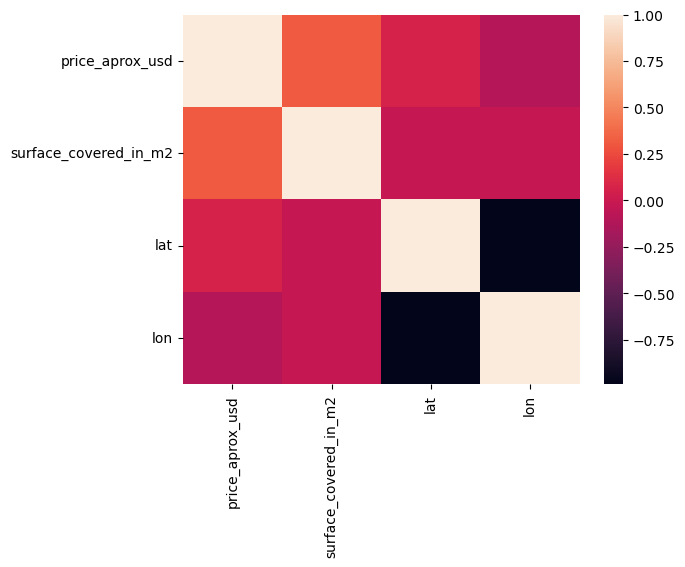

In [55]:
sns.heatmap(df1.corr())

Use glob to create the list `files`. It should contain the filenames of all the Mexico City real estate XLSXs in the `./data` directory, except for `mexico-city-test-features.xlsx`.

In [56]:
files = glob("data/mexico-city-real-estate-*.xlsx")
files

['data/mexico-city-real-estate-5.xlsx',
 'data/mexico-city-real-estate-4.xlsx',
 'data/mexico-city-real-estate-3.xlsx',
 'data/mexico-city-real-estate-2.xlsx',
 'data/mexico-city-real-estate-1.xlsx']

Combine the `wrangle` function, a list comprehension, and `pd.concat` to create a DataFrame `df`. It should contain all the properties from the five XLSXs in `files`.

In [57]:
frames = [wrangle(file) for file in files]

In [58]:
df = pd.concat(frames, ignore_index=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,82737.39,75.0,19.362690,-99.150565,Benito Juárez
1,72197.60,62.0,19.291345,-99.124312,Tlalpan
2,44277.72,85.0,19.354987,-99.061709,Iztapalapa
3,60589.45,52.0,19.469681,-99.086136,Gustavo A. Madero
4,47429.08,53.0,19.443592,-99.121407,Venustiano Carranza


## Explore

Create a histogram showing the distribution of apartment prices (`"price_aprox_usd"`) in `df`. Label the x-axis `"Price [$]"`, the y-axis `"Count"`, and give it the title `"Distribution of Apartment Prices"`. Use Matplotlib (`plt`).

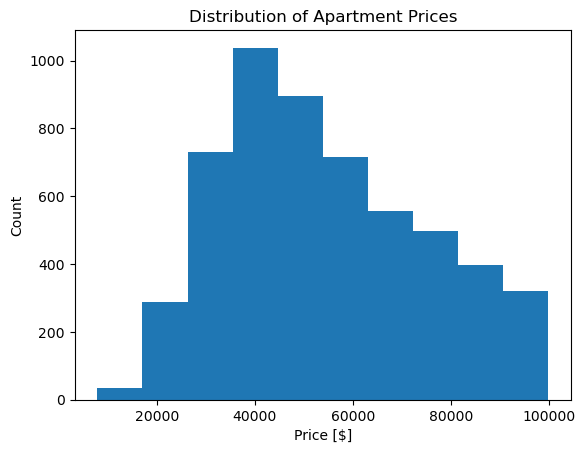

In [59]:
# Build histogram
plt.hist(df["price_aprox_usd"])


# Label axes
plt.xlabel("Price [$]")
plt.ylabel("Count")
# Add title
plt.title("Distribution of Apartment Prices")

# Don't delete the code below 👇
plt.savefig("images/2-5-4.png", dpi=150)

Create a scatter plot that shows apartment price (`"price_aprox_usd"`) as a function of apartment size (`"surface_covered_in_m2"`). Label the x-axis `"Area [sq meters]"` and y-axis `"Price [USD]"`. The plot should have the title `"Mexico City: Price vs. Area"`. Use Matplotlib (`plt`).

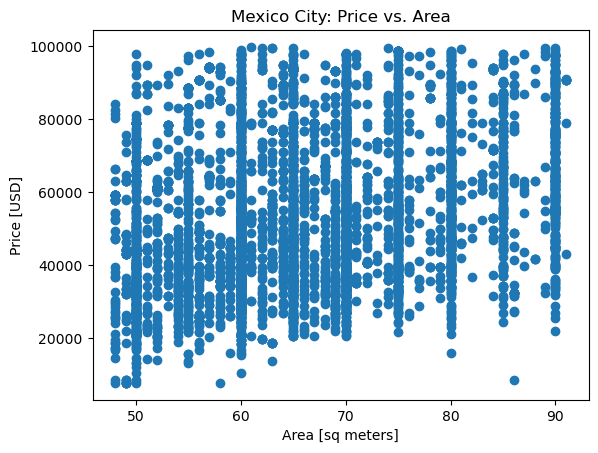

In [60]:
# Build scatter plot
plt.scatter(x= df["surface_covered_in_m2"], y = df["price_aprox_usd"] )


# Label axes
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
# Add title
plt.title("Mexico City: Price vs. Area")

# Don't delete the code below 👇
plt.savefig("images/2-5-5.png", dpi=150)

Create a Mapbox scatter plot that shows the location of the apartments in your dataset and represent their price using color.

In [61]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat="lat",
    lon="lon",
    width=600,  # Width of map
    height=600,  # Height of map
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

## Split

Create the feature matrix `X_train` and target vector `y_train`. The target is `"price_aprox_usd"`. The features should be all the columns that remain in the DataFrame you cleaned above.

In [62]:
# Split data into feature matrix `X_train` and target vector `y_train`.
target = "price_aprox_usd"
features = ["surface_covered_in_m2", "lat", "lon", "borough"]
X_train = df[features]
y_train = df[target]

# Build Model

## Baseline

Calculate the baseline mean absolute error for your model.

In [63]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", round(y_mean, 2))
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.53
Baseline MAE: 17239.939475888317


## Iterate

Create a pipeline named `model` that contains all the transformers necessary for this dataset and one of the predictors was used during this project. Then fit the model to the training data.

In [64]:
# Build Model
model = make_pipeline(OneHotEncoder(use_cat_names=True), SimpleImputer(), Ridge())
# Fit model
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate

Read the XLSX file `mexico-city-test-features.xlsx` into the DataFrame `X_test`.

In [65]:
X_test = pd.read_excel("data/mexico-city-test-features.xlsx")
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   int64  
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60,19.493185,-99.205755,Azcapotzalco
1,55,19.307247,-99.166700,Coyoacán
2,50,19.363469,-99.010141,Iztapalapa
3,60,19.474655,-99.189277,Azcapotzalco
4,74,19.394628,-99.143842,Benito Juárez


Check that the <code>X_train</code> you used to train your model has the same column order as <code>X_test</code>. Otherwise, it may hurt the model's performance.

In [66]:
X_train.head()

,surface_covered_in_m2,lat,lon,borough
0,75.0,19.362690,-99.150565,Benito Juárez
1,62.0,19.291345,-99.124312,Tlalpan
2,85.0,19.354987,-99.061709,Iztapalapa
3,52.0,19.469681,-99.086136,Gustavo A. Madero
4,53.0,19.443592,-99.121407,Venustiano Carranza


Use the model to generate a Series of predictions for `X_test`.

In [67]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53538.366480
1    53171.988369
2    34263.884179
3    53488.425607
4    68738.924884
dtype: float64

In [75]:
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(coefficients, index=features).sort_values(ascending=True)
feat_imp

borough_Tláhuac                  -14166.869486
borough_Iztapalapa               -13349.017448
borough_Gustavo A. Madero         -6637.429757
borough_La Magdalena Contreras    -5925.666450
borough_Venustiano Carranza       -5609.918629
lon                               -2492.221814
borough_Cuauhtémoc                 -350.531990
surface_covered_in_m2               291.654156
borough_Iztacalco                   405.403127
lat                                 478.901375
borough_Xochimilco                  929.857400
borough_Miguel Hidalgo             1977.314718
borough_Azcapotzalco               2459.288646
borough_Álvaro Obregón             3275.121061
borough_Coyoacán                   3737.561001
borough_Cuajimalpa de Morelos      9157.269123
borough_Tlalpan                   10319.429804
borough_Benito Juárez             13778.188880
dtype: float64

Create a horizontal bar chart that shows the **10 most influential** coefficients for the model. Label x- and y-axis `"Importance [USD]"` and `"Feature"`, respectively, and give the chart the title `"Feature Importances for Apartment Price"`. Use pandas.

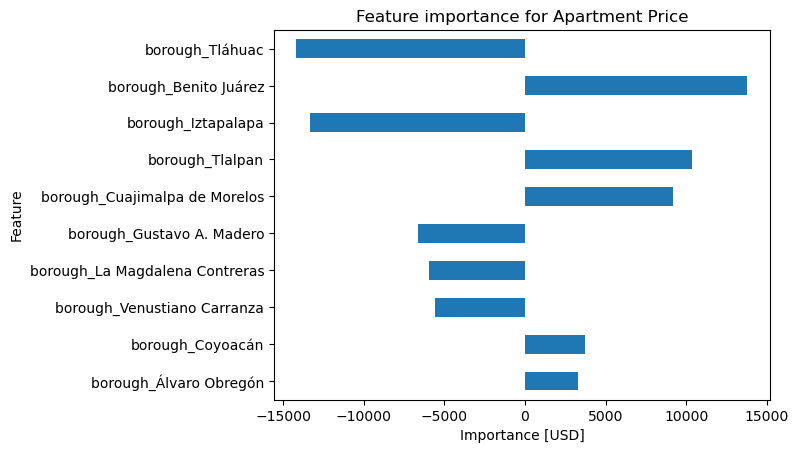

In [79]:
feat_imp.sort_values(key=abs).tail(10).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature importance for Apartment Price");